In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import yfinance as yf
import matplotlib.pyplot as plt

# EDA

In [6]:
df = pd.read_csv("/Users/mitalisoni/Documents/DataAnalyst/Data Science Projects/apple_stock_data.csv")
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2023-11-02 00:00:00+00:00,176.665985,177.570007,177.779999,175.460007,175.520004,77334800
1,2023-11-03 00:00:00+00:00,175.750671,176.649994,176.820007,173.350006,174.240005,79763700
2,2023-11-06 00:00:00+00:00,178.317520,179.229996,179.429993,176.210007,176.380005,63841300
3,2023-11-07 00:00:00+00:00,180.894333,181.820007,182.440002,178.970001,179.179993,70530000
4,2023-11-08 00:00:00+00:00,181.958893,182.889999,183.449997,181.589996,182.350006,49340300


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       252 non-null    object 
 1   Adj Close  252 non-null    float64
 2   Close      252 non-null    float64
 3   High       252 non-null    float64
 4   Low        252 non-null    float64
 5   Open       252 non-null    float64
 6   Volume     252 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB


In [10]:
df.describe()

,Adj Close,Close,High,Low,Open,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,199.088202,199.454286,201.093056,197.608373,199.316032,5.832214e+07
std,21.511933,21.321567,21.571427,20.963034,21.365476,3.025771e+07
min,164.585999,165.000000,166.399994,164.080002,165.350006,2.404830e+07
25%,182.254063,182.852501,184.617504,181.487499,182.777504,4.278855e+07
50%,192.370026,193.084999,194.399994,191.724998,192.989998,5.174865e+07
75%,221.697502,221.697502,224.149994,219.717499,221.635002,6.497460e+07
max,236.479996,236.479996,237.490005,234.449997,236.479996,3.186799e+08


# Data Transformation

In [12]:
#Converting Date column to datetime type and keeping on the close values
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close']]

In [14]:
df.head()

,Close
Date,
2023-11-02 00:00:00+00:00,177.570007
2023-11-03 00:00:00+00:00,176.649994
2023-11-06 00:00:00+00:00,179.229996
2023-11-07 00:00:00+00:00,181.820007
2023-11-08 00:00:00+00:00,182.889999


In [16]:
#Scaling close values between 0 & 1 so it is compatible with LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = df.copy()
df['Close'] = scaler.fit_transform(df[['Close']])
df.head(10)

,Close
Date,
2023-11-02 00:00:00+00:00,0.175853
2023-11-03 00:00:00+00:00,0.162983
2023-11-06 00:00:00+00:00,0.199077
2023-11-07 00:00:00+00:00,0.235311
2023-11-08 00:00:00+00:00,0.250280
2023-11-09 00:00:00+00:00,0.243565
2023-11-10 00:00:00+00:00,0.299384
2023-11-13 00:00:00+00:00,0.277001
2023-11-14 00:00:00+00:00,0.313934


In [18]:
df.describe()

,Close
count,252.000000
mean,0.482013
std,0.298287
min,0.000000
25%,0.249755
50%,0.392907
75%,0.793194
max,1.000000


Appending sequences of last 60 days in X and appending stock value on the 61st day as the corresponding y value.

In [20]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(df['Close'].values, seq_length)

We will be using a combination of the LSTM (Long Short-Term Memory) model and a Linear regresion model to predict stock prices.

Combining an LSTM model and a Linear Regression model for stock price prediction leverages the strengths of both approaches to improve accuracy. LSTMs excel at capturing temporal dependencies and modeling non-linear relationships in sequential data, making them suitable for analyzing time series like stock prices. On the other hand, Linear Regression identifies linear trends and provides simplicity and robustness to overfitting, especially with limited data. By combining these models, their weaknesses are compensated for—LSTMs address complex patterns, while Linear Regression captures simpler trends. Using hybrid predictions, weighted by inverse RMSE, balances the contributions of each model, resulting in improved accuracy and more robust predictions that account for both long-term trends and short-term dynamics in stock price behavior.

# LSTM Model

In [22]:
#Splitting Train & Test Data set
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
#Defining the LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [26]:
#Compile model with appropriate loss and optimizer function
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=16, batch_size=32)

Epoch 1/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2560
Epoch 2/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0361
Epoch 3/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0369
Epoch 4/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0212
Epoch 5/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0213
Epoch 6/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0144
Epoch 7/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0152
Epoch 8/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0116
Epoch 9/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104
Epoch 10/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0099
Epoch 11/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0097
Epoch 12/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087
Epoch 13/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0100
Epoch 14/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0098
Epoch 15/16
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0093
Epoch 16/16
5/5 ━━━━━━━━━━━━━━━━━━

# Linear Regression Model

In [32]:
#Adding lag features with prices from last 3 days
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)
df['Lag_3'] = df['Close'].shift(3)
df = df.dropna()

In [34]:
df.head()

,Close,Lag_1,Lag_2,Lag_3
Date,,,,
2023-11-07 00:00:00+00:00,0.235311,0.199077,0.162983,0.175853
2023-11-08 00:00:00+00:00,0.250280,0.235311,0.199077,0.162983
2023-11-09 00:00:00+00:00,0.243565,0.250280,0.235311,0.199077
2023-11-10 00:00:00+00:00,0.299384,0.243565,0.250280,0.235311
2023-11-13 00:00:00+00:00,0.277001,0.299384,0.243565,0.250280


In [36]:
df.tail()

,Close,Lag_1,Lag_2,Lag_3
Date,,,,
2024-10-28 00:00:00+00:00,0.956911,0.929071,0.917320,0.919978
2024-10-29 00:00:00+00:00,0.960688,0.956911,0.929071,0.917320
2024-10-30 00:00:00+00:00,0.910744,0.960688,0.956911,0.929071
2024-10-31 00:00:00+00:00,0.852127,0.910744,0.960688,0.956911
2024-11-01 00:00:00+00:00,0.810157,0.852127,0.910744,0.960688


In [38]:
#Splitting Train & Test Data set
X_lin = df[['Lag_1', 'Lag_2', 'Lag_3']]
y_lin = df['Close']
X_train_lin, X_test_lin = X_lin[:train_size-3], X_lin[train_size-3:]
y_train_lin, y_test_lin = y_lin[:train_size-3], y_lin[train_size-3:]

In [40]:
#Defining the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train_lin, y_train_lin)

LinearRegression()

In [28]:
#Making predictions on LSTM model
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_predictions = lstm_model.predict(X_test_lstm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


In [30]:
#Calculating rmse for LSTM model
mse = mean_squared_error(y_test, lstm_predictions)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 0.061614593981601545


In [42]:
#Inverse transforming scaled predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

In [44]:
#Making predictions on Linear Regression Model
lin_predictions = lin_model.predict(X_test_lin)

#Calculating rmse for Linear Regression model
mse_lin = mean_squared_error(y_test_lin, lin_predictions)
rmse_lin = np.sqrt(mse_lin)
print(f"Root Mean Squared Error: {rmse_lin}")

Root Mean Squared Error: 0.044158020035671854


In [46]:
lin_predictions = scaler.inverse_transform(lin_predictions.reshape(-1, 1))

In [48]:
# Calculate the inverse RMSE for each model
inverse_rmse_lstm = 1 / rmse
inverse_rmse_lr = 1 / rmse_lin

# Calculate the total of the inverse RMSE values
total_inverse_rmse = inverse_rmse_lstm + inverse_rmse_lr

# Calculate the weight for each model based on inverse RMSE
w_lstm = inverse_rmse_lstm / total_inverse_rmse
w_lr = inverse_rmse_lr / total_inverse_rmse

print(f"weight for LSTM model is: {w_lstm}")
print(f"weight for Linear Regression model is: {w_lr}")

weight for LSTM model is: 0.41748065362609404
weight for Linear Regression model is: 0.582519346373906


# Future Prediction

Predicting stock closing value for next 15 days after the last date in our data file. We will compare this with the actual stock closing prices from that day using the yfinance package.

In [112]:
lstm_future_predictions = []
last_sequence = X[-1].reshape(1, seq_length, 1)
for _ in range(15):
    lstm_pred = lstm_model.predict(last_sequence)[0, 0]
    lstm_future_predictions.append(lstm_pred)
    lstm_pred_reshaped = np.array([[lstm_pred]]).reshape(1, 1, 1)
    last_sequence = np.append(last_sequence[:, 1:, :], lstm_pred_reshaped, axis=1)
lstm_future_predictions = scaler.inverse_transform(np.array(lstm_future_predictions).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [114]:
lstm_future_predictions

array([[232.40308],
       [232.21791],
       [232.06752],
       [231.9479 ],
       [231.85384],
       [231.78   ],
       [231.72159],
       [231.67455],
       [231.6357 ],
       [231.60251],
       [231.57315],
       [231.54634],
       [231.52104],
       [231.4967 ],
       [231.47292]], dtype=float32)

In [108]:
recent_data = df['Close'].values[-3:]
lin_future_predictions = []
for _ in range(15):
    lin_pred = lin_model.predict(recent_data.reshape(1, -1))[0]
    lin_future_predictions.append(lin_pred)
    recent_data = np.append(recent_data[1:], lin_pred)
lin_future_predictions = scaler.inverse_transform(np.array(lin_future_predictions).reshape(-1, 1))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does 

In [110]:
lin_future_predictions

array([[230.14018566],
       [225.42525994],
       [222.40603746],
       [230.21381129],
       [224.91940674],
       [221.90049629],
       [230.32293674],
       [224.38965855],
       [221.39398538],
       [230.46972786],
       [223.83297479],
       [220.88725999],
       [230.6564645 ],
       [223.24603926],
       [220.38124486]])

In [116]:
hybrid_future_predictions = (0.42 * lstm_future_predictions) + (0.58 * lin_future_predictions)

In [120]:
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=15, freq='B')
future_dates = future_dates.date
predictions_df = pd.DataFrame({
    'Date': future_dates,
    'LSTM Predictions': lstm_future_predictions.flatten(),
    'Linear Regression Predictions': lin_future_predictions.flatten(),
    'Hybrid Model Predictions': hybrid_future_predictions.flatten()
})
predictions_df = predictions_df.set_index('Date')
print(predictions_df)

            LSTM Predictions  Linear Regression Predictions  \
Date                                                          
2024-11-04        232.403076                     230.140186   
2024-11-05        232.217911                     225.425260   
2024-11-06        232.067520                     222.406037   
2024-11-07        231.947906                     230.213811   
2024-11-08        231.853836                     224.919407   
2024-11-11        231.779999                     221.900496   
2024-11-12        231.721588                     230.322937   
2024-11-13        231.674545                     224.389659   
2024-11-14        231.635696                     221.393985   
2024-11-15        231.602509                     230.469728   
2024-11-18        231.573151                     223.832975   
2024-11-19        231.546341                     220.887260   
2024-11-20        231.521042                     230.656464   
2024-11-21        231.496704                     223.24

In [122]:
stock_data = yf.download("AAPL", start="2024-11-02", end="2024-11-23")
stock_data[['Close']]

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2024-11-04,222.009995
2024-11-05,223.449997
2024-11-06,222.720001
2024-11-07,227.479996
2024-11-08,226.960007
2024-11-11,224.229996
2024-11-12,224.229996
2024-11-13,225.119995
2024-11-14,228.220001


In [124]:
df_final = pd.DataFrame(index = stock_data.index)
df_final["Actual"] = stock_data[["Close"]]
df_final["Predicted"] = predictions_df["Hybrid Model Predictions"]
df_final

,Actual,Predicted
Date,,
2024-11-04,222.009995,231.090599
2024-11-05,223.449997,228.278168
2024-11-06,222.720001,226.463855
2024-11-07,227.479996,230.942132
2024-11-08,226.960007,227.831865
2024-11-11,224.229996,226.049883
2024-11-12,224.229996,230.910370
2024-11-13,225.119995,227.449309
2024-11-14,228.220001,225.695499


In [126]:
#Calculating rmse for hybrid model
mse_hyb = mean_squared_error(df_final["Actual"], df_final["Predicted"])
rmse_hyb = np.sqrt(mse_hyb)
print(f"Root Mean Squared Error: {rmse_hyb}")

Root Mean Squared Error: 4.22436660150953


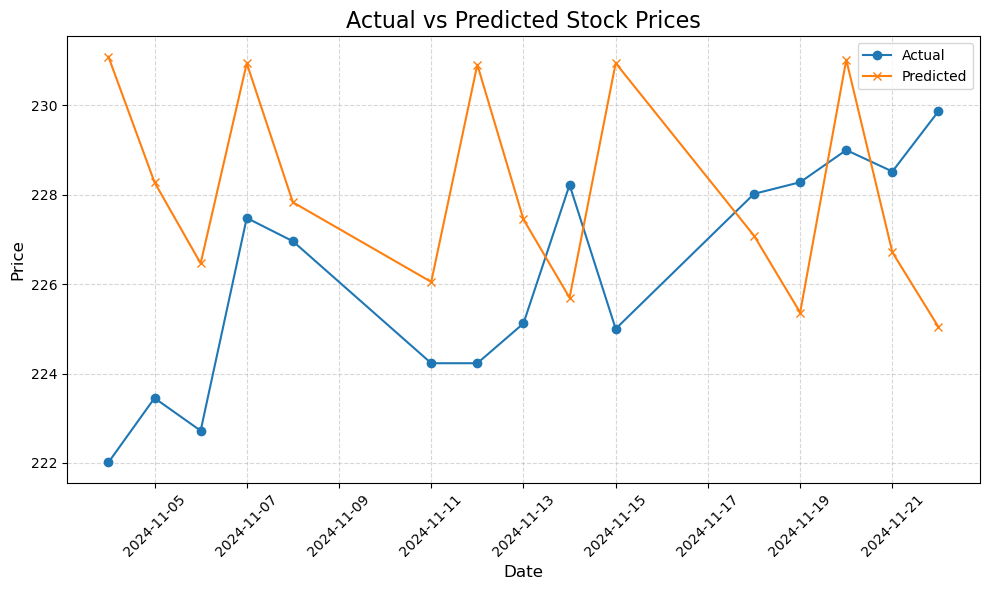

In [128]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_final.index, df_final["Actual"], label="Actual", marker='o')
plt.plot(df_final.index, df_final["Predicted"], label="Predicted", marker='x')

# Customize the chart
plt.title("Actual vs Predicted Stock Prices", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better visibility

# Display the plot
plt.tight_layout()
plt.show()

# Conclusion

The hybrid model combining LSTM and linear regression demonstrated its capability to predict stock prices by leveraging the strengths of both deep learning and traditional machine learning approaches. With a Root Mean Squared Error (RMSE) of 4.22, the model showed a reasonable performance, capturing general price trends while highlighting areas for further refinement. The comparison of actual versus predicted stock prices over a 15-day forecast period reveals that the hybrid model aligns closely with real values but could be improved for certain fluctuations.

Overall, the project illustrates the potential of hybrid models in stock price forecasting by achieving a balance between sequence modeling and simpler predictive structures. Future work could involve refining hyperparameters, incorporating additional market features (e.g., sentiment analysis or macroeconomic indicators) to enhance prediction accuracy further. The insights gained through this model provide a robust foundation for making informed decisions in stock market analysis.